## Parse results from RSSAC002 
### https://github.com/rssac-caucus/RSSAC002-data/

In [576]:
import sys
from datetime import timedelta, datetime
from datetime import datetime
from dateutil.parser import parse
import pandas as pd
import cfscrape
import re
from bs4 import BeautifulSoup
import yaml


In [577]:
def find_urls(initial_date,final_date):
    curr_day = initial_date
    array_urls = []
    while (curr_day <= final_date):
        print (curr_day)
        curr_day = curr_day + timedelta(days=1)  
        url ="https://github.com/rssac-caucus/RSSAC002-data/tree/master/{}/{:02d}/traffic-volume".format(curr_day.year,curr_day.month)
        array_urls.append(url)
    return (array_urls)

In [578]:
def get_content_url(df):
    
    result = []
    for url in df.url.unique():
        print (url)
        scraper = cfscrape.create_scraper()
        scraped_html=scraper.get(url).content
        soup = BeautifulSoup(scraped_html, 'lxml')
        

        # find all links on the URL
        for link in soup.find_all('a', href=True, title=True):
            title = (link.get('title'))
            if (re.search(r".*root.*yaml",title)) is not None:
                
                full_path = "{}/{}".format(url,title)
                
                raw_prefix = "https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master"
                suffix = "/".join(full_path.split("/")[7:])
                raw_url = "{}/{}".format(raw_prefix,suffix)

                filename = full_path.split("/")[-1]
                matched =  re.search(r'([a-z])-root-(\d{8})-', filename)
                root = matched.group(1)
                date = matched.group(2)

                temp = dict(
                    root = root,
                    date = date,
                    url = raw_url
                )
                result.append(temp)
    return (result)

In [579]:
str = "https://github.com/rssac-caucus/RSSAC002-data/tree/master/2019/01/traffic-volume/m-root-20190119-traffic-volume.yaml"

In [580]:
raw_prefix = "https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master"
suffix = "/".join(str.split("/")[7:])
print ("{}/{}".format(raw_prefix,suffix))

https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/m-root-20190119-traffic-volume.yaml


# MAIN

In [583]:
initial = "2019-01-09"
final   = "2019-01-16"

# convert to time structured
initial_date = datetime.strptime(initial, '%Y-%m-%d')
final_date = datetime.strptime(final, '%Y-%m-%d')

array_urls = find_urls(initial_date,final_date)
df_url = pd.DataFrame(array_urls, columns=['url'])
result = get_content_url(df_url)
# print (result)
df = pd.DataFrame(result)
df["date"] = pd.to_datetime( df.date, format="%Y/%m/%d")
df.head()
# filter time window
df = df[(df['date'] >= initial) & (df['date'] <= final)]
df.head()

2019-01-09 00:00:00
2019-01-10 00:00:00
2019-01-11 00:00:00
2019-01-12 00:00:00
2019-01-13 00:00:00
2019-01-14 00:00:00
2019-01-15 00:00:00
2019-01-16 00:00:00
https://github.com/rssac-caucus/RSSAC002-data/tree/master/2019/01/traffic-volume


,root,date,url
8,a,2019-01-09,https://raw.githubusercontent.com/rssac-caucus...
9,a,2019-01-10,https://raw.githubusercontent.com/rssac-caucus...
10,a,2019-01-11,https://raw.githubusercontent.com/rssac-caucus...
11,a,2019-01-12,https://raw.githubusercontent.com/rssac-caucus...
12,a,2019-01-13,https://raw.githubusercontent.com/rssac-caucus...


In [584]:
total_of_root_server =  len(df.root.unique())
print ("We found stats for {} root-letters".format(total_of_root_server))
print ("time windows: {} - {} ".format(df.date.min(),df.date.max()))

temp_df = df.groupby(['date'])['root'].count().reset_index()
days_with_measurements_for_all_roots = temp_df[temp_df.root>=total_of_root_server]['date'].to_list()

# filter day list
df = df[df.date.isin(days_with_measurements_for_all_roots)]
print ("We found {} days with measurements for all nodes".format(len(df.date.unique())))

We found stats for 12 root-letters
time windows: 2019-01-09 00:00:00 - 2019-01-16 00:00:00 
We found 8 days with measurements for all nodes


In [585]:
# get raw data content
def get_stats(url):
    scraper = cfscrape.create_scraper()
    scraped_html=scraper.get(url).content
    scraped_html
    soup = BeautifulSoup(scraped_html, 'lxml')
    values = soup.find_all("p")[0]
    values = values.renderContents()
    return (pd.pandas.json_normalize(yaml.load(values)))

In [595]:
df_result_all = pd.DataFrame()
for url in df.url.unique():
    print (url)
    df_result = get_stats(url)
    df_result_all = pd.concat([df_result_all, df_result])

https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190109-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190110-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190111-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190112-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190113-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190114-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190115-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/a-root-20190116-traf

https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/j-root-20190111-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/j-root-20190112-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/j-root-20190113-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/j-root-20190114-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/j-root-20190115-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/j-root-20190116-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/k-root-20190109-traffic-volume.yaml
https://raw.githubusercontent.com/rssac-caucus/RSSAC002-data/master/2019/01/traffic-volume/k-root-20190110-traf

In [596]:
df_result_all.drop('end-period',axis=1,inplace=True)
df_result_all.drop('version',axis=1,inplace=True)
df_result_all.head(2)

,service,start-period,metric,dns-udp-queries-received-ipv4,dns-udp-queries-received-ipv6,dns-tcp-queries-received-ipv4,dns-tcp-queries-received-ipv6,dns-udp-responses-sent-ipv4,dns-udp-responses-sent-ipv6,dns-tcp-responses-sent-ipv4,dns-tcp-responses-sent-ipv6
0,a.root-servers.net,2019-01-09T00:00:00Z,traffic-volume,4894158793,683437812,137563184,32347873,4782737110,682954325,134320198,33002374
0,a.root-servers.net,2019-01-10T00:00:00Z,traffic-volume,4947362022,717149297,196602353,31578197,4835961957,716616903,193331272,32427409


In [597]:
# convert root-server names to short 
di = { 
    'a.root-servers.net': 'a',
    'b.root-servers.net': 'b',
    'c.root-servers.net': 'c',
    'd.root-servers.net': 'd',
    'e.root-servers.net': 'e',
    'f.root-servers.net': 'f',
    'g.root-servers.net': 'g',
    'h.root-servers.net': 'h',
    'i.root-servers.net': 'i',
    'j.root-servers.net': 'j',
    'l.root-servers.net': 'l',
    'm.root-servers.net': 'm',
}
df_result_all['service'] = df_result_all['service'].map(di)
df_result_all.head(1)

,service,start-period,metric,dns-udp-queries-received-ipv4,dns-udp-queries-received-ipv6,dns-tcp-queries-received-ipv4,dns-tcp-queries-received-ipv6,dns-udp-responses-sent-ipv4,dns-udp-responses-sent-ipv6,dns-tcp-responses-sent-ipv4,dns-tcp-responses-sent-ipv6
0,a,2019-01-09T00:00:00Z,traffic-volume,4894158793,683437812,137563184,32347873,4782737110,682954325,134320198,33002374


In [430]:
# df_result_all.to_csv("RSSAC002-data.csv")

In [99]:
#df_result_all = pd.read_csv("RSSAC002-data.csv")
#df_result_all.drop("Unnamed: 0",axis=1,inplace=True)
df_result_all.head(1)

,service,start-period,metric,dns-udp-queries-received-ipv4,dns-udp-queries-received-ipv6,dns-tcp-queries-received-ipv4,dns-tcp-queries-received-ipv6,dns-udp-responses-sent-ipv4,dns-udp-responses-sent-ipv6,dns-tcp-responses-sent-ipv4,dns-tcp-responses-sent-ipv6
0,a,2019-01-09T00:00:00Z,traffic-volume,4894158793,683437812,137563184,32347873,4782737110,682954325,134320198,33002374


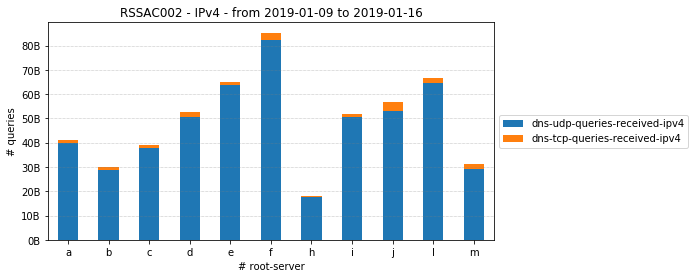

In [599]:
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import ticker
%matplotlib inline

fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))

df_result_all.groupby(['service'])[['dns-udp-queries-received-ipv4','dns-tcp-queries-received-ipv4']].sum().plot(
    kind="bar",
    ax= ax,
    stacked=True)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels,rotation=0);
ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
import matplotlib.pyplot as plt
plt.ticklabel_format(style='plain', axis='y');
ax.set_yticklabels(['{:1}B'.format(int(x/1000000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# queries');
ax.set_xlabel('# root-server');
ax.set_title("RSSAC002 - IPv4 - from {} to {}".format(initial,final));  

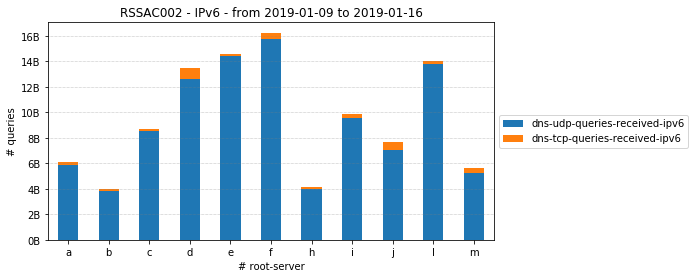

In [601]:
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import ticker
%matplotlib inline

fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))

df_result_all.groupby('service')[['dns-udp-queries-received-ipv6','dns-tcp-queries-received-ipv6']].sum().plot(
    kind="bar",
    ax= ax,
    stacked=True)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels,rotation=0);
ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
import matplotlib.pyplot as plt
plt.ticklabel_format(style='plain', axis='y');
ax.set_yticklabels(['{:1}B'.format(int(x/1000000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# queries');
ax.set_xlabel('# root-server');
ax.set_title("RSSAC002 - IPv6 - from {} to {}".format(initial,final));  

In [566]:
# total ipv4 + ipv6
data = df_result_all.groupby('service')[['dns-udp-queries-received-ipv6','dns-udp-queries-received-ipv4','dns-tcp-queries-received-ipv6','dns-tcp-queries-received-ipv4']].sum()
lst = data.sum(axis=1).div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

47395143307 &33902031628 &47721532064 &65860831963 &79506416758 &101503031889 &22150472424 &61545253618 &64325896667 &80745843699 &36759660094 \\


In [567]:
# total ipv4
data = df_result_all.groupby('service')[['dns-udp-queries-received-ipv4','dns-tcp-queries-received-ipv4']].sum()
lst = data.sum(axis=1).div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

41289688598 &29909107784 &39004878123 &52422934011 &64953407379 &85269163262 &18030267276 &51694068213 &56639926786 &66740328011 &31142064032 \\


In [568]:
# udp ipv4
data = df_result_all.groupby('service')['dns-udp-queries-received-ipv4'].sum()
lst = data.div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

39843254342 &28609583275 &37758700250 &50473594048 &63549880138 &82200921747 &17681533050 &50532640275 &53136103502 &64651907902 &29351816799 \\


In [569]:
# tcp ipv4
data = df_result_all.groupby('service')['dns-tcp-queries-received-ipv4'].sum()
lst = data.div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

1446434256 &1299524509 &1246177873 &1949339963 &1403527241 &3068241515 &348734226 &1161427938 &3503823284 &2088420109 &1790247233 \\


In [570]:
# total ipv6
data = df_result_all.groupby('service')[['dns-udp-queries-received-ipv6','dns-tcp-queries-received-ipv6']].sum()
lst = data.sum(axis=1).div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

6105454709 &3992923844 &8716653941 &13437897952 &14553009379 &16233868627 &4120205148 &9851185405 &7685969881 &14005515688 &5617596062 \\


In [571]:
# udp ipv6
data = df_result_all.groupby('service')['dns-udp-queries-received-ipv6'].sum()
lst = data.div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

5835664584 &3816511370 &8492023500 &12594758419 &14388142734 &15759873522 &4001975769 &9552674718 &7055086698 &13759649821 &5247618969 \\


In [572]:
# tcp ipv6
data = df_result_all.groupby('service')['dns-tcp-queries-received-ipv6'].sum()
lst = data.div(1).apply(lambda x: '%.f' % x).to_list()
print ("{} \\\\".format(" &".join(lst)))

269790125 &176412474 &224630441 &843139533 &164866645 &473995105 &118229379 &298510687 &630883183 &245865867 &369977093 \\
